Executing KSVDDL...


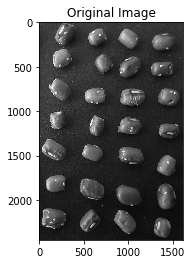

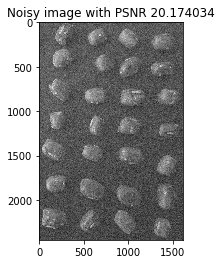

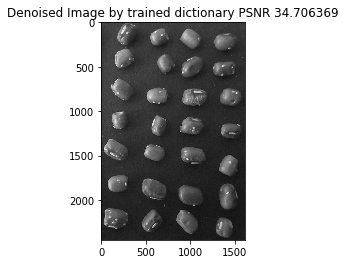

Total Time: 12.901306283473968


In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pylab as plt
from time import time
from im2col import im2col
from omperr import omperr
from KSVDDL import KSVDDL

def DenoiseImage(Image,Param,seed):
    NN1,NN2 = Image.shape
    C = 1.15
    bb = 8
    maxNumBlocksToTrainOn = 1000
    sigma = Param.noise
    K = Param.k
    class Par():
        pass
    param=Par()
    param.K = K
    param.I = range(K)
    param.itN = 10
    param.errorGoal = sigma*C

    # first, train a dictionary on blocks from the noisy image
    if np.prod(np.array([NN1,NN2])-bb+1) > maxNumBlocksToTrainOn:
        np.random.seed(seed)
        randPermutation =  np.random.permutation(np.prod(np.array([NN1,NN2])-bb+1))
        selectedBlocks = randPermutation[0:maxNumBlocksToTrainOn]
        blkMatrix = np.zeros((bb**2,maxNumBlocksToTrainOn))
        for i in range(maxNumBlocksToTrainOn):
            row,col = np.unravel_index(selectedBlocks[i],tuple(np.array(Image.shape)-bb+1),order='F')
            currBlock = Image[row:row+bb,col:col+bb]
            blkMatrix[:,i] = np.reshape(currBlock,(-1,),order='F')
    else:
        blkMatrix = im2col(Image,(bb,bb))
        
    ######## Make initial dictionary from DCT ###########
    Pn = int(np.ceil(np.sqrt(K)))
    DCT = np.zeros((bb,Pn))
    for k in range(Pn):
        V = np.cos(np.array(range(bb))*k*np.pi/Pn)
        if k > 0:
            V = V-np.mean(V)
        DCT[:,k] = V/np.linalg.norm(V)
    DCT = np.kron(DCT,DCT)


    #####################################################
    param.initialDictionary = DCT[:,0:param.K]
    
    # reducedc
    vecOfMeans = np.mean(blkMatrix,axis=0)
    blkMatrix = blkMatrix-np.dot(np.ones((blkMatrix.shape[0],1)),np.reshape(vecOfMeans,(1,-1),order='F'))


    if(Param.method == 'KSVDDL'):
        print('Executing KSVDDL...')
        Dictionary = KSVDDL(blkMatrix,param)
    else:
        raise('No Method Defined')

    #denoise the image using the resulted dictionary
    errT = sigma*C    
    blocks = im2col(Image,(bb,bb))
    idx = range(blocks.shape[1])
    # go with jumps of 30000
    for jj in range(0,blocks.shape[1],30000):
        jumpSize = min(jj+30000,blocks.shape[1])
        #reduceDC
        vecOfMeans = np.mean(blocks[:,jj:jumpSize],axis=0)
        blocks[:,jj:jumpSize] = blocks[:,jj:jumpSize] - np.tile(vecOfMeans,(blocks.shape[0],1))
        Coefs = omperr(Dictionary,blocks[:,jj:jumpSize],errT)
        #reducedc
        blocks[:,jj:jumpSize] = np.dot(Dictionary,Coefs) + \
        np.dot(np.ones((blocks.shape[0],1)),np.reshape(vecOfMeans,(1,-1),order='F'))
    
    count = 0
    Weight = np.zeros((NN1,NN2))
    IMout = np.zeros((NN1,NN2))
    rows,cols = np.unravel_index(idx,tuple(np.array(Image.shape)-bb+1),order='F')
    for i in range(len(cols)):
        col = cols[i]
        row = rows[i]
        block = np.reshape(blocks[:,count],(bb,bb),order='F')
        IMout[row:row+bb,col:col+bb] = IMout[row:row+bb,col:col+bb] + block
        Weight[row:row+bb,col:col+bb] = Weight[row:row+bb,col:col+bb] + np.ones((bb,bb))
        count = count+1
    
    IOut = (Image+0.034*sigma*IMout)/(1.0+0.034*sigma*Weight)
    return IOut

if __name__ == "__main__":
    tic = time()
    class Para():
        pass
    Param = Para()
    Param.k = 256 #dictionary atoms
    Param.noise = 25
    Param.method = 'KSVDDL'
    ImageName = 'moong.jpg'
    seed = 1
    
    Img = cv2.imread(ImageName,0)
    OriginalImage = np.float64(Img)
    np.random.seed(seed)
    NoisedImage = OriginalImage + Param.noise*np.random.standard_normal(OriginalImage.shape)

    # Denoise the corrupted image using learned dicitionary from corrupted image
    DenoisedImage = DenoiseImage(NoisedImage, Param,seed)

    NoisedPSNR = 20.0*np.log10(255.0/np.sqrt(np.mean((NoisedImage-OriginalImage)**2)))
    DenoisedPSNR = 20.0*np.log10(255.0/np.sqrt(np.mean((DenoisedImage-OriginalImage)**2)))

    # Display the results
    plt.close('all')
    plt.figure()
    plt.imshow(OriginalImage,cmap='gray')
    plt.title('Original Image')
    plt.show()
    plt.imshow(NoisedImage,cmap='gray')
    plt.title('Noisy image with PSNR %f' %NoisedPSNR)
    plt.show()    
    plt.imshow(DenoisedImage,cmap='gray'); 
    plt.title('Denoised Image by trained dictionary PSNR %f' %DenoisedPSNR)
    plt.show()
    print("Total Time:", (time()-tic)/60.0)